In [1]:
import numpy as np
import matplotlib.pyplot as plt
from arc import *
import pickle
import scipy.optimize as opt
import scipy
from budget_monte_carlo import *
from linear_response_2photon import response_2photon, build_Oseq_2photon, O2photon_I1, O2photon_I2, O2photon_nu1, O2photon_nu2
from linear_response import build_Oseq, response_G13, isometry_haar_full
import phase_noise #import procData, p0dict_638
import pandas as pd

In [2]:
h = 6.626e-34
e = 1.602e-19
a0 = 5.291e-11
hbar = h/2/np.pi
EH = 4.359744e-18
c = 299792458
kb = 1.380649e-23
me = 9.1093837e-31
epi0 = 8.854e-12
bohr_r = 5.291e-11
w_qubit = 9192631770*2*np.pi

<h2>Configuration</h2>

In [54]:
atom_name = 'Cs'
n=63

Omega_Rabi = 8*2*np.pi


atom_d = 2.8 #um
# Omega_Rabi = 5*2*np.pi #MHz*2pi

inter_detuning = 5000*2*np.pi #MHz*2pi

Bz = 10 #G
pulse_time= 7.65 #Omega_Rabi
resolution = 200 # number of phase steps in the pulse


w0_rydberg = 50 #um
lambda_rydberg = 0.459 #um

w0_rydberg1 = 50 #um
lambda_rydberg1 = 1.038 #um
# HF_split = 500*np.pi*2 # MHz

T_atom = 5 #uK
trap_depth = 1000 #uK
lambda_trap = 1.064 #um
w0_trap = 1.2 #um

edc_fluc = 1e-3 #V/cm
edc_zero = 0 #V/m
bdc_fluc = 1e-3 #G

num_samples =1000

pol_dc = 282


phase_noise_csv = "638_20MHz-2-2-2026.csv"
RIN_csv_path = '319_Intensity_0.442VDC.csv' 
RIN_background_csv_path = 'UV_intensity_background.csv'
intensity_DC_V = 0.442

# Blockade
with open('6363_blockade.pkl', 'rb') as file:
    # Load the object from the file
    blockade2_dict = pickle.load(file)
def find_blockade_Mrad_2photon(atom_name, n, d):
    # blockades = blockade2_dict[atom_name][str(n)]
    b_r = blockade2_dict['r']
    b_values = blockade2_dict['blockade_MHz']
    b = np.interp(d, b_r, b_values)
    return b * 2 * np.pi

In [55]:
if atom_name == "Rb":
    atom = Rubidium()
elif atom_name == "Cs":
    atom = Caesium()
blockade_mrad = find_blockade_Mrad_2photon(atom_name, n, atom_d)
print('Blockade:', blockade_mrad/2/np.pi , 'MHz')
R_lifetime = atom.getStateLifetime(n=n,l=0,j=1/2,temperature=300, includeLevelsUpTo=n+20,s=0.5)*1e6
m_atom = atom.mass

Blockade: 327.14884039119653 MHz


In [56]:
#### 2 photons gate ###

Omega1_0 = np.sqrt(2*Omega_Rabi*inter_detuning)
Omega2_0 = np.sqrt(2*Omega_Rabi*inter_detuning)
Delta = inter_detuning#

v_photon1 = atom.getTransitionFrequency(n1=6, l1=0, j1=1/2, n2=7, l2=1, j2=1/2, s=0.5)
v_photon1 += inter_detuning*1e6/2/np.pi
v_photon2 = atom.getTransitionFrequency(n1=6, l1=1, j1=1/2, n2=n, l2=0, j2=1/2, s=0.5)
v_photon2 -= inter_detuning*1e6/2/np.pi

alpha_g_gen = DynamicPolarizability(atom, n=6, l=1, j=1/2, s=0.5)
alpha_g_gen.defineBasis(6, 9)
alpha_r_gen = DynamicPolarizability(atom, n=n, l=0, j=1/2, s=0.5)
alpha_r_gen.defineBasis(6, n+20)

alpha_r_1 = alpha_r_gen.getPolarizability(c/(v_photon1), units='SI', accountForStateLifetime=False, mj=None)[0]
d1 = atom.getDipoleMatrixElement(n1=6, l1=0, j1=1/2, mj1=-1/2, n2=7, l2=1, j2=1/2, mj2=1/2,q=1, s=0.5)*bohr_r/hbar*e

ktilde0_1 = -(1/4/(Delta+w_qubit/1e6)-1/4/Delta)
ktilder_1 = -(alpha_r_1*2*np.pi*1e6)/4/d1**2+1/4/Delta

d2 = atom.getDipoleMatrixElement(n1=7, l1=1, j1=1/2, mj1=1/2, n2=n, l2=0, j2=1/2, mj2=-1/2,q=-1, s=0.5)*bohr_r/hbar*e
alpha_1_2 = alpha_g_gen.getPolarizability(c/(v_photon2), units='SI', accountForStateLifetime=False, mj=None)[0]

ktilde0_2 = 0.0
ktilder_2 = -1/4/Delta+(alpha_1_2*2*np.pi*1e6)/4/d2**2

delta1 = (ktilder_1*Omega1_0**2+ktilder_2*Omega2_0**2)
delta2 = 0

<h2>Find optimized phase</h2>

Infidelity before optimizer: 0.0011292722950514422
Infidelity after optimizer: 0.0005499628464273876
phase parameter [ 0.82788888  0.93477939 -1.13685747 -0.0651374 ]
7.057136153232335e-08


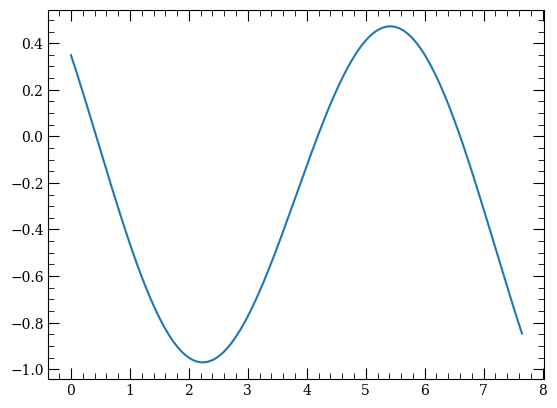

In [57]:
H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
PhaseGuess = [2*np.pi*0.1122, 1.0431, -0.7318, 0]
time, phase_guess, dt = phase_cosine_generate(*PhaseGuess, H_gen.pulse_time,H_gen.resolution)
# fid_optimize(PhaseGuess, H_gen)
# H_gen.return_fidel
fid, global_phi = H_gen.return_fidel(phases=phase_guess, dt=dt)
print('Infidelity before optimizer:', 1-fid)
opt_out=opt.minimize(fun=fid_optimize,x0=PhaseGuess,args=(H_gen))
phase_params = opt_out.x
# print(phase_params)
infid_TO_theory = opt_out.fun
print('Infidelity after optimizer:', infid_TO_theory) 
print('phase parameter', phase_params)
H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=1e10, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=1e10, pulse_time=pulse_time)
time, phase, dt = phase_cosine_generate(*phase_params, H_gen.pulse_time,H_gen.resolution)
fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
infid_TO = 1-fid
print(infid_TO)
plt.plot(time, phase)
##%%


<h2>Budget_calculation</h2>

In [58]:
doppler_shift = (1/lambda_rydberg-1/lambda_rydberg1)/1e-6*np.sqrt(kb*(T_atom*1e-6)/m_atom)
print('doppler shift:', doppler_shift/2/np.pi, 'Hz')

calc = StarkMap(atom)
if pol_dc is None:
    calc.defineBasis(n=n, l=0, j=0.5, mj=-0.5, nMin=n-20, nMax=n+30, maxL=5, Bz=Bz/10000)
    calc.diagonalise(np.linspace(0,1,100))
    pol_dc = calc.getPolarizability(debugOutput=True)
delta_edc = abs(-1/2*pol_dc*1e6*((edc_zero+edc_fluc)**2-edc_zero**2))*2*np.pi 
print('Electric DC fluctuation:', delta_edc/2/np.pi, 'Hz')

delta_bdc = atom.getZeemanEnergyShift(l=0, j=1/2, mj=-1/2, magneticFieldBz=bdc_fluc/10000)/hbar
print('Magnetic DC fluctuation:', delta_bdc/2/np.pi, 'Hz')

total_shift = np.sqrt(delta_bdc**2+ delta_edc**2 + doppler_shift**2)
print('Total DC detuning fluctuation:', total_shift/2/np.pi, 'Hz')
detunings = total_shift/1e6/Omega_Rabi
print('delta/Ω:', detunings)
print('==============')
infids_s = []
for i in range(num_samples):
    d = sample_gaussian(detunings)
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=10e9, Delta1=d, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=10e9, pulse_time=pulse_time)
    fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
    infids_s.append(1-fid)
infids_s = np.asarray(infids_s)
infids_detuning = np.mean(infids_s)-infid_TO
infids_detiuning_std = infids_s.std(ddof=1)
infids_bdc = delta_bdc**2/total_shift**2*infids_detuning
infids_edc = delta_edc**2/total_shift**2*infids_detuning
infids_doppler = doppler_shift**2/total_shift**2*infids_detuning

print(f'total error due to detuning: {infids_detuning} +/- {infids_detiuning_std}')
print('error due to E field: {}'.format(infids_edc))
print('error due to B field: {}'.format(infids_bdc))
print('error due to doppler: {}'.format(infids_doppler))

infids_s = []
infids_blockade = []
infids_rabi = []
sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
ds, c1, c2, = sample_pair_distances(
        n_samples=num_samples,
        sigma_r=sigma_r,
        sigma_z=sigma_z,
        x_offset=atom_d,
        rng=None
)
x1 = c1['x']
y1 = c1['y']
z1 = c1['z']
x2 = c2['x']
y2 = c2['y']
z2 = c2['z']
rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi
infids_s = []
infids_blockade =[]
infids_rabi =[]
for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
    blockade = find_blockade_Mrad_2photon(atom_name, n, d)
    # total
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=10e9, Delta1=0, 
                     Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=10e9, pulse_time=pulse_time)
    fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
    infids_s.append(1-fid)

    H_gen_block = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=10e9, Delta1=0, 
                 Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=10e9, pulse_time=pulse_time)
    fid, global_phi = H_gen_block.asym_return_fidel(phases=phase, dt=dt, omega1_scale=1, omega2_scale=1)
    infids_blockade.append(1-fid)

    H_gen_rabi = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=10e9, Delta1=0, 
                 Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=10e9, pulse_time=pulse_time)
    fid, global_phi = H_gen_rabi.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
    infids_rabi.append(1-fid)
infids_s = np.asarray(infids_s)
infids_motion = np.mean(infids_s) - infid_TO
infids_motion_std = infids_s.std(ddof=1)

infids_blockade = np.asarray(infids_blockade)
infids_motion_blockade = np.mean(infids_blockade) - infid_TO
infids_motion_blockade_std = infids_blockade.std(ddof=1)

infids_rabi = np.asarray(infids_rabi)
infids_motion_rabi = np.mean(infids_rabi) - infid_TO
infids_motion_rabi_std = infids_rabi.std(ddof=1)

print(f'total error due to atom motion: {infids_motion} +/- {infids_motion_std}')
print(f'total error due to atom motion(blockade): {infids_motion_blockade} +/- {infids_motion_blockade_std}')
print(f'total error due to atom motion(rabi): {infids_motion_rabi} +/- {infids_motion_rabi_std}')

# delta_mj = atom.getZeemanEnergyShift(l=1, j=3/2, mj=3/2, magneticFieldBz=Bz/10000)/hbar/1e6 - \
# atom.getZeemanEnergyShift(l=1, j=3/2, mj=1/2, magneticFieldBz=Bz/10000)/hbar/1e6
###Scattering off intermediate state
tau_7p = atom.getStateLifetime(n=7,l=1,j=1/2,temperature=300, includeLevelsUpTo=n+20,s=0.5)*1e6
scattering_e = 0.95/Omega_Rabi/tau_7p*Omega1_0**2/(inter_detuning+w_qubit)**2 + 0.95/Omega_Rabi/tau_7p*(Omega1_0**2+Omega2_0**2)/(inter_detuning)**2+0.12/Omega_Rabi/tau_7p*(Omega1_0**2-Omega2_0**2)/(inter_detuning)**2
print('error due to scattering:', scattering_e)


loss_decay = (2.95/(Omega_Rabi))/R_lifetime
print('error due to Rydberg decay:', loss_decay)

phase_noise_data = phase_noise.procData(phase_noise_csv, True, "638nm", range=20e6, p0=phase_noise.p0dict_638)
label = phase_noise_data[1][1]
vnoise_data = phase_noise_data[1][0]
vnoise_fs = []
vnoise_W = []
for d in vnoise_data:
    if d[0] >=0:
        vnoise_fs.append(d[0]/1e6)
        vnoise_W.append(d[1]*d[0]**2)

vnoise_fs= np.array(vnoise_fs)
vnoise_W = np.array(vnoise_W)
S_haar = isometry_haar_full()   # D=4
T = 2 * np.pi * 1.215 /Omega_Rabi
t_real = np.linspace(0.0, T, resolution)
dt_real = t_real[1] - t_real[0]
oOseq_nu1 = build_Oseq_2photon(phases=phase, dt=dt_real, B=blockade_mrad, Omega1=Omega1_0, Omega2=Omega2_0, delta1=delta1, 
                            delta2=delta2, Delta=Delta, inter_detuning=inter_detuning, n=n, Oinst_func=O2photon_nu1)
vnoise_contribution = []
for i in range(len(vnoise_fs)-1):
    deltaf = vnoise_fs[i+1]-vnoise_fs[i]
    If_2p_1 = response_2photon(oOseq_nu1, S_haar, vnoise_fs[i]*2*np.pi, dt_real)
    vnoise_contribution.append((If_2p_1*2)*vnoise_W[i]*deltaf/1e6)
vnoise_error= np.sum(vnoise_contribution)
print('error due to laser phase noise:', vnoise_error)

intensity_noise_csv = pd.read_csv(RIN_csv_path, header=None)
background_noise_csv = pd.read_csv(RIN_background_csv_path, header=None)
fs_intensity = intensity_noise_csv[0]
RIN_db = intensity_noise_csv[1]
fs_background = background_noise_csv[0]
bg_db = background_noise_csv[1]
rbw = fs_intensity[1]-fs_intensity[0]
carrier_p = (intensity_DC_V**2/50*1e3) #dBm

bg_w = db_to_w(bg_db)
raw_RIN_w = db_to_w(RIN_db)
RIN_db_c = w_to_db(np.where((raw_RIN_w-bg_w)<0,1e-99,raw_RIN_w-bg_w))
RIN_dbc = (RIN_db_c-w_to_db(carrier_p)-w_to_db(rbw)) #convert to dBc/Hz= db(W_RIN/W_carrier/Hz) = db(W_RIN)-db(W_carrier)-db(Hz) 

# fig , ax = plt.subplots(ncols=2)
# ax[0].plot(fs_intensity, RIN_dbc)
# ax[0].plot(fs_intensity, RIN_db)
RIN_W = db_to_w(RIN_dbc)
fs_intensity = np.array(fs_intensity)
RIN_W = np.array(RIN_W)
RIN_contribution = []
oOseq_I1 = build_Oseq_2photon(phases=phase, dt=dt_real, B=blockade_mrad, Omega1=Omega1_0, Omega2=Omega2_0, delta1=delta1, 
                    delta2=delta2, Delta=Delta, inter_detuning=inter_detuning, n=n, Oinst_func=O2photon_I1)
oOseq_I2 = build_Oseq_2photon(phases=phase, dt=dt_real, B=blockade_mrad, Omega1=Omega1_0, Omega2=Omega2_0, delta1=delta1, 
                    delta2=delta2, Delta=Delta, inter_detuning=inter_detuning, n=n, Oinst_func=O2photon_I2)

RIN_contribution = []
# fs  = np.linspace(0,15,500)
# for f in fs:
for i in range(len(fs_intensity)-2):
    deltaf = fs_intensity[i+2]-fs_intensity[i+1]
    Ii_2p_1 = response_2photon(oOseq_I1, S_haar, fs_intensity[i+2]*2*np.pi/1e6, dt_real)
    Ii_2p_2 = response_2photon(oOseq_I2, S_haar, fs_intensity[i+2]*2*np.pi/1e6, dt_real)
    RIN_contribution.append((Ii_2p_1+Ii_2p_2)*RIN_W[i+2]*deltaf)

RIN_error = np.sum(RIN_contribution)
print('error due to RIN:', RIN_error)


total_error = loss_decay  + infids_motion + infids_detuning+scattering_e+RIN_error+vnoise_error
print('total error:', total_error)

doppler shift: 0.0 Hz
Electric DC fluctuation: 141.0 Hz
Magnetic DC fluctuation: -1401.262404421114 Hz
Total DC detuning fluctuation: 1408.3384983888077 Hz
delta/Ω: 0.00017604231229860097
total error due to detuning: 3.792238933985725e-11 +/- 5.31121434454016e-10
error due to E field: 3.8011920767549084e-13
error due to B field: 3.7542270132181755e-11
error due to doppler: 0.0
total error due to atom motion: 5.167376170003846e-06 +/- 1.0142736127089547e-05
total error due to atom motion(blockade): 5.132824981176509e-06 +/- 1.0081692761286472e-05
total error due to atom motion(rabi): 1.1764711560835467e-08 +/- 1.4353760053326612e-08
error due to scattering: 0.0007840025846809436
error due to Rydberg decay: 0.0005486758603536883
error due to laser phase noise: 8.237437451870651e-05
error due to RIN: 0.00012498829034645416
total error: 0.0015452085239921858


In [50]:
from matplotlib.colors import to_rgb, to_hex
def _blend(c, target=(1, 1, 1), t=0.35):
    """Blend color c toward target by fraction t (t=0 -> original, t=1 -> target)."""
    c = np.array(to_rgb(c), dtype=float)
    target = np.array(target, dtype=float)
    return tuple((1 - t) * c + t * target)

def paper_pastel_colors(n, base="Accent"):
    """
    Colors like the screenshot: soft/pastel categorical colors with enough variety.
    Uses a base qualitative palette (default Accent) and expands it by lightness levels.
    """
    cmap = plt.get_cmap(base)
    # Accent has 8 "base" colors; .colors exists for ListedColormap
    base_colors = list(getattr(cmap, "colors", [cmap(i) for i in np.linspace(0, 1, 8)]))

    # Lightness variants: (toward white) fractions.
    # First level ~ your screenshot; later levels add more distinct pastels.
    levels = [0.28]  # pastel, lighter pastel, slightly less pastel

    colors = []
    for t in levels:
        for c in base_colors:
            colors.append(_blend(c, target=(1, 1, 1), t=t))

    # If still not enough, add a slightly darker set (toward black) — still paper-friendly.
    if len(colors) < n:
        for c in base_colors:
            colors.append(_blend(c, target=(0, 0, 0), t=0.10))

    return colors[:n]
def plot_two_gate_hatched_comparison_accent(
    gateA: dict,
    gateB: dict,
    order,
    gateA_name="Gate A",
    gateB_name="Gate B",
    logy=True,
    ylim=None,
    omega_label=None,
    title=None,
    savepath=None,
):
    labels = list(order)

    yA = np.array([gateA.get(k, np.nan) for k in labels], float)
    yB = np.array([gateB.get(k, np.nan) for k in labels], float)

    # Log-safe floor
    eps = 1e-30
    if logy:
        yA = np.where(np.isfinite(yA) & (yA > 0), yA, eps)
        yB = np.where(np.isfinite(yB) & (yB > 0), yB, eps)

    x = np.arange(len(labels))
    w = 0.36

    # ---- Accent colormap ----
    cmap = plt.cm.Dark2
    # colors = accent_plus_tab(len(labels))
    colors = paper_pastel_colors(len(labels), base="Accent")
    # colors = cmap(np.linspace(0, 1, len(labels)))

    fig, ax = plt.subplots(figsize=(6.8, 3.8), dpi=150)

    # ---- Gate A: solid ----
    ax.bar(
        x - w/2, yA,
        width=w,
        color=colors,
        alpha=0.75,
        edgecolor="black",
        linewidth=0.9,
        label=gateA_name,
        zorder=2,
    )

    # ---- Gate B: hatched, same color ----
    ax.bar(
        x + w/2, yB,
        width=w,
        facecolor="none",
        edgecolor=colors,
        linewidth=1.2,
        hatch="///",
        label=gateB_name,
        zorder=3,
    )

    # Axis formatting
    ax.set_ylabel("Infidelity")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=35, ha="right")

    if logy:
        ax.set_yscale("log")

    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ymax = max(yA.max(), yB.max())
        ymin = min(yA.min(), yB.min())
        ax.set_ylim(ymin / 2, ymax * 2) if logy else ax.set_ylim(0, 1.15 * ymax)

    # ax.grid(axis="y", which="both", alpha=0.25)
    ax.set_axisbelow(True)
    ax.legend(frameon=False, loc="upper right")

    if omega_label:
        ax.text(
            0.05, 0.88,
            omega_label,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=9,
        )

    if title:
        ax.set_title(title, fontsize=10)

    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, bbox_inches="tight")
    return fig, ax

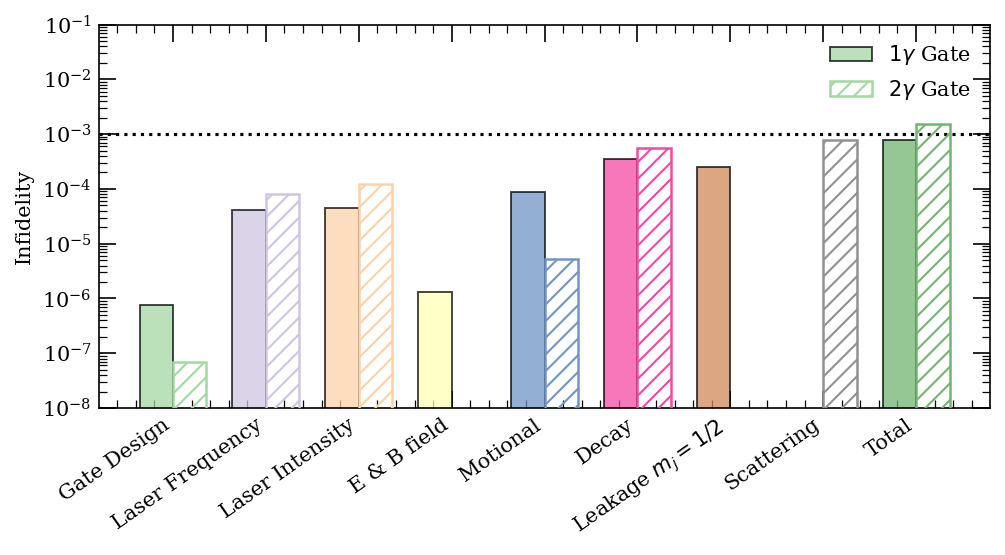

In [59]:
photon1 = {'Gate Design': np.float64(7.703633273514754e-07),
 'Laser Frequency': np.float64(4.144296790872857e-05),
 'Laser Intensity': np.float64(4.3933427539275665e-05),
 'E & B field': np.float64(1.3070568240681127e-06),
 'Motional': np.float64(8.75953051526744e-05),
 'Decay': np.float64(0.0003476752053037448),
 'Leakage $m_j=1/2$': 0.00025593448077292216,
 'Scattering': 0,
 'Total': 0.0007786588068287654}
experiment = None
labels = ("Gate Design", "Laser Frequency", "Laser Intensity", "E & B field", "Motional", "Decay", 'Leakage $m_j=1/2$', "Scattering", "Total")
photon2 = {
    # keep baseline values for things you did NOT change
    "Gate Design": infid_TO,
    "Laser Frequency": vnoise_error,
    "Laser Intensity": RIN_error,
    "E & B field": infids_edc + infids_bdc,
    "Motional": infids_motion ,
    "Decay": loss_decay,
    'Leakage $m_j=1/2$': 0,
    "Scattering": scattering_e,
    "Total":total_error
}

fig ,ax = plot_two_gate_hatched_comparison_accent(
    gateA=photon1,
    gateB=photon2,
    order=labels,
    gateA_name="$1\gamma$ Gate",
    gateB_name="$2\gamma$ Gate",
    logy=True,
    ylim=[1e-8,1e-1],
    omega_label=None,
    title=None,
    savepath=None,
)
ax.axhline(1e-3, c='k', linestyle=":")
fig.savefig('1photon-2photon.pdf')

In [38]:
experiment = None
labels = ("Gate Design", "Laser Frequency", "Laser Intensity", "E & B field", "Motional", "Decay", 'Leakage $m_j=1/2$', "Scattering", "Total")
photon2 = {
    # keep baseline values for things you did NOT change
    "Gate Design": infid_TO,
    "Laser Frequency": vnoise_error,
    "Laser Intensity": RIN_error,
    "E & B field": infids_edc + infids_bdc,
    "Motional": infids_motion ,
    "Decay": loss_decay,
    'Leakage $m_j=1/2$': 0
    "Scattering": scattering_e
}

fig, ax = plot_error_budget(
    optimized,          # dict: {"Decay": val, "Frequency": val, ...} in absolute infidelity units (e.g. 1e-3)
    component_err=None,  # dict: {"Decay": std, ...} same units; optional
    experiment=experiment,     # float, experimental infidelity (same units); optional
    experiment_label=None,  # str label in the plot; optional
    omega_label=False,#r"$\Omega = 2\pi \times$" + " {:.2f}MHz".format(Omega_Rabi/2/np.pi),
    title=None,
    savepath=None,
)
ax.set_yscale('log')
ax.axhline(1e-3, c='k', linestyle=':')
ax.set_ylim([5e-7,3e-1])
fig.savefig('50p_gate.pdf')

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3403189673.py, line 11)

<h2>Infidelity</h2>

In [ ]:
phase_noise_csv = "638_20MHz-2-2-2026.csv"
RIN_csv_path = '319_Intensity_0.442VDC.csv' 
RIN_background_csv_path = 'UV_intensity_background.csv'
intensity_DC_V = 0.442

phase_noise_data = phase_noise.procData(phase_noise_csv, True, "638nm", range=20e6, p0=phase_noise.p0dict_638)
label = phase_noise_data[1][1]
vnoise_data = phase_noise_data[1][0]
vnoise_fs = []
vnoise_W = []
for d in vnoise_data:
    if d[0] >=0:
        vnoise_fs.append(d[0]/1e6)
        vnoise_W.append(d[1]*d[0]**2)

print('fitted frequency noise')
# fig, ax = plt.subplots()
# ax.plot(vnoise_fs, vnoise_W, label=label)
# ax.set_yscale('log')
# # ax.set_xscale('log')
# ax.set_ylabel('Frequency PSD [Hz$^2$/Hz]')
# ax.set_xlabel('frequency [MHz]')
vnoise_fs= np.array(vnoise_fs)
vnoise_W = np.array(vnoise_W)
# fs  = np.linspace(0,15,500)
# for f in fs:



intensity_noise_csv = pd.read_csv(RIN_csv_path, header=None)
background_noise_csv = pd.read_csv(RIN_background_csv_path, header=None)
fs_intensity = intensity_noise_csv[0]
RIN_db = intensity_noise_csv[1]
fs_background = background_noise_csv[0]
bg_db = background_noise_csv[1]
rbw = fs_intensity[1]-fs_intensity[0]
carrier_p = (intensity_DC_V**2/50*1e3) #dBm

bg_w = db_to_w(bg_db)
raw_RIN_w = db_to_w(RIN_db)
RIN_db_c = w_to_db(np.where((raw_RIN_w-bg_w)<0,1e-99,raw_RIN_w-bg_w))
RIN_dbc = (RIN_db_c-w_to_db(carrier_p)-w_to_db(rbw)) #convert to dBc/Hz= db(W_RIN/W_carrier/Hz) = db(W_RIN)-db(W_carrier)-db(Hz) 

# fig , ax = plt.subplots(ncols=2)
# ax[0].plot(fs_intensity, RIN_dbc)
# ax[0].plot(fs_intensity, RIN_db)
RIN_W = db_to_w(RIN_dbc)
fs_intensity = np.array(fs_intensity)
RIN_W = np.array(RIN_W)



S_haar = isometry_haar_full()   # D=4
o_f= build_Oseq(phases=phase1, dt=dt, B=blockade_mrad, is_intensity=False)
o_I = build_Oseq(phases=phase1, dt=dt, B=blockade_mrad, is_intensity=True)

v_1photon = []
v_2photon = []
RIN_1photon = []
RIN_2photon = []
decay_1photon = []
decay_2photon = []
infids_motion1 = []
infids_motion2 = []
f_Rabis = np.linspace(1,10,50)
Omega_Rabis = 2*np.pi*f_Rabis
sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
ds, c1, c2, = sample_pair_distances(
        n_samples=num_samples,
        sigma_r=sigma_r,
        sigma_z=sigma_z,
        x_offset=atom_d,
        rng=None
)
for Omega_Rabi in Omega_Rabis:
    Omega1_0 = np.sqrt(2*Omega_Rabi*inter_detuning)
    Omega2_0 = np.sqrt(2*Omega_Rabi*inter_detuning)
    delta1 = (ktilder_1*Omega1_0**2+ktilder_2*Omega2_0**2)
    delta2 = 0
    T = 2 * np.pi * 1.215 /Omega_Rabi
    t_real = np.linspace(0.0, T, resolution)
    dt_real = t_real[1] - t_real[0]
    oOseq_nu1 = build_Oseq_2photon(phases=phase2, dt=dt_real, B=blockade_mrad, Omega1=Omega1_0, Omega2=Omega2_0, delta1=delta1, 
                            delta2=delta2, Delta=Delta, inter_detuning=inter_detuning, n=n, Oinst_func=O2photon_nu1)
    vnoise1_contribution = []
    vnoise2_contribution = []
    for i in range(len(vnoise_fs)-1):
        deltaf = vnoise_fs[i+1]-vnoise_fs[i]
        #
        If_1 = response_G13(o_f, S_haar, vnoise_fs[i]*2*np.pi/Omega_Rabi, dt=dt)/Omega_Rabi**2
        vnoise1_contribution.append(If_1*vnoise_W[i]*deltaf/1e6)
    
        If_2p_1 = response_2photon(oOseq_nu1, S_haar, vnoise_fs[i]*2*np.pi, dt_real)
        # If_2p_2 = response_2photon(oOseq_nu2, S_haar, vnoise_fs[i]/1e6*2*np.pi, dt_real)
        vnoise2_contribution.append((If_2p_1*2)*vnoise_W[i]*deltaf/1e6)
    # plt.plot(f[:-1], vnoise_contribution)
    v_1photon.append(np.sum(vnoise1_contribution))
    v_2photon.append(np.sum(vnoise2_contribution))
    # print('error due to laser phase noise:', vnoise_error)
    
    oOseq_I1 = build_Oseq_2photon(phases=phase2, dt=dt_real, B=blockade_mrad, Omega1=Omega1_0, Omega2=Omega2_0, delta1=delta1, 
                        delta2=delta2, Delta=Delta, inter_detuning=inter_detuning, n=n, Oinst_func=O2photon_I1)
    oOseq_I2 = build_Oseq_2photon(phases=phase2, dt=dt_real, B=blockade_mrad, Omega1=Omega1_0, Omega2=Omega2_0, delta1=delta1, 
                        delta2=delta2, Delta=Delta, inter_detuning=inter_detuning, n=n, Oinst_func=O2photon_I2)
    Inoise1_contribution = []
    Inoise2_contribution = []
    # fs  = np.linspace(0,15,500)
    # for f in fs:
    for i in range(len(fs_intensity)-2):
        deltaf = fs_intensity[i+2]-fs_intensity[i+1]
        Ii = response_G13(o_I, S_haar, fs_intensity[i+2]*2*np.pi/1e6/Omega_Rabi, dt=dt)
        Inoise1_contribution.append(Ii*RIN_W[i+2]*deltaf)
        Ii_2p_1 = response_2photon(oOseq_I1, S_haar, fs_intensity[i+2]*2*np.pi/1e6, dt_real)
        Ii_2p_2 = response_2photon(oOseq_I2, S_haar, fs_intensity[i+2]*2*np.pi/1e6, dt_real)
        Inoise2_contribution.append((Ii_2p_1+Ii_2p_2)*RIN_W[i+2]*deltaf)
    RIN_1photon.append(np.sum(Inoise1_contribution))
    RIN_2photon.append(np.sum(Inoise2_contribution))



    decay_1photon.append((2.95/(Omega_Rabi))/R_lifetime_1photon)
    decay_2photon.append((2.95/(Omega_Rabi))/R_lifetime_2photon)

    infids_s1 = []
    infids_s2 = []
    for d in ds:
        blockade1 = find_blockade_Mrad(atom_name, n, d)
        blockade2 = find_blockade_Mrad_2photon(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade1, r_lifetime=1e10, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=1e10, pulse_time=pulse_time)
        fid, global_phi = H_gen.asym_return_fidel(phases=phase1, dt=dt, omega1_scale=1, omega2_scale=1)
        infids_s1.append(1-fid)

        H_gen2 = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade2, r_lifetime=1e10, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=1e10, pulse_time=pulse_time)
        fid2, global_phi = H_gen.asym_return_fidel(phases=phase2, dt=dt, omega1_scale=1, omega2_scale=1)
        infids_s2.append(1-fid2)
    infids_s1 = np.asarray(infids_s1)
    infids_motion1.append(np.mean(infids_s1) - infid_TO1)

    infids_s2 = np.asarray(infids_s2)
    infids_motion2.append(np.mean(infids_s2) - infid_TO2)
    # print('error due to Rydberg decay:', loss_decay)


# plt.plot(fs[:-1], contribution)
# RIN_error = np.sum(RIN_contribution)
# print('error due to RIN:', RIN_error)

fitted frequency noise


In [ ]:
v_1photon = np.array(v_1photon)
RIN_1photon = np.array(RIN_1photon)
infids_motion1 = np.array(infids_motion1)
decay_1photon = np.array(decay_1photon)
v_2photon = np.array(v_2photon)
RIN_2photon = np.array(RIN_2photon)
infids_motion2 = np.array(infids_motion2)
decay_2photon = np.array(decay_2photon)
sum_1photon = v_1photon+ RIN_1photon+infids_motion1+decay_1photon
sum_2photon = v_2photon+ RIN_2photon+infids_motion2+decay_2photon

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(f_Rabis, v_1photon, c="#4e63ff", linewidth=2)
ax.plot(f_Rabis, RIN_1photon, c="#ff4da6", linewidth=2)
ax.plot(f_Rabis, infids_motion1, c="#2ecc71", linewidth=2)
ax.plot(f_Rabis, decay_1photon, c="#7f8c8d", linewidth=2)
ax.plot(f_Rabis, sum_1photon, c="k", linewidth=4)

ax.set_ylabel("Infidelity", fontsize=14)
ax.set_xlabel("$\Omega/ 2\pi$ [MHz] ", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_yscale('log')

fig2, ax2 = plt.subplots(figsize=(6,5))
ax2.plot(f_Rabis, v_2photon, c="#4e63ff", linewidth=2)
ax2.plot(f_Rabis, RIN_2photon, c="#ff4da6", linewidth=2)
ax2.plot(f_Rabis, infids_motion2, c="#2ecc71", linewidth=2)
ax2.plot(f_Rabis, decay_2photon, c="#7f8c8d", linewidth=2)
ax2.plot(f_Rabis, sum_2photon, c="k", linewidth=4)
fig2.text( 0.5,0.5, 'Motion',c="#2ecc71")

# ax2.plot(f_Rabis, exponant(f_Rabis,*fit_RIN2[0]), c='k', )
ax2.set_ylabel("Infidelity", fontsize=14)
ax2.set_xlabel("$\Omega/ 2\pi$ [MHz] ", fontsize=14)
ax2.tick_params(labelsize=12)
ax2.set_yscale('log')





In [ ]:
###Scattering off intermediate state

0.95/Omega_Rabi/tau_7p*Omega1_0**2/(inter_detuning-w_qubit)**2

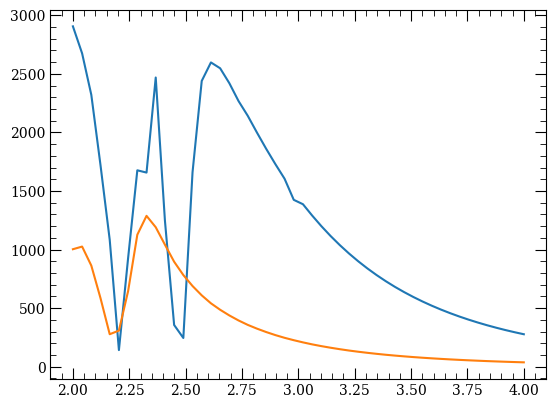

In [122]:
r = np.linspace(2,4,50)
plt.plot(r, find_blockade_Mrad_2photon(atom_name, n , r))

r = np.linspace(2,4,50)
plt.plot(r, find_blockade_Mrad(atom_name, n , r))

In [93]:
def exponant(f,a,b,e):
    return a*f**e+b
fit_RIN1 = opt.curve_fit(exponant, f_Rabis*1e6, RIN_1photon,  p0=[1e-5,0,0.05])
fit_RIN2 = opt.curve_fit(exponant, f_Rabis*1e6, RIN_2photon,  p0=[1e-5,0,0.08])
print('RIN1:', fit_RIN1[0])
print('RIN2:', fit_RIN2[0])

RIN1: [1.35985945e-10 4.89218445e-06 7.91114597e-01]
RIN2: [ 7.21037798e-09 -3.89417031e-06  6.15915879e-01]


(5e-07, 0.005)

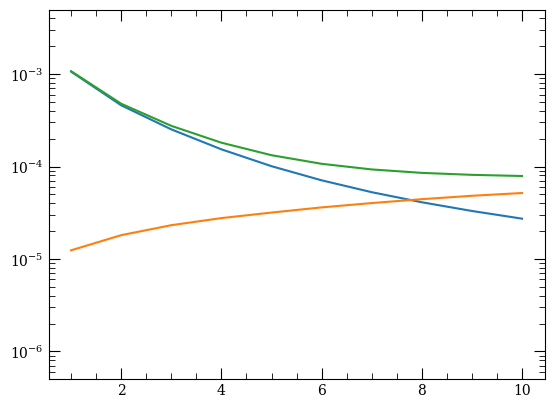

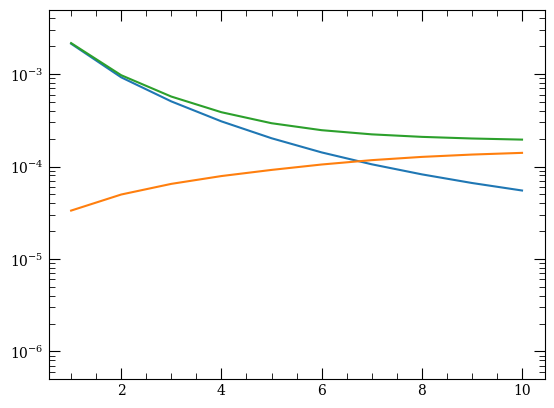

In [34]:
fig, ax = plt.subplots()

ax.plot(f_Rabis, v_1photon)
ax.plot(f_Rabis, RIN_1photon)
ax.set_yscale('log')
ax.plot(f_Rabis,RIN_1photon+v_1photon)
ax.set_ylim([0.5e-6,5e-3])
fig2, ax2 = plt.subplots()
ax2.plot(f_Rabis, v_2photon)
ax2.plot(f_Rabis, RIN_2photon)
ax2.plot(f_Rabis,RIN_2photon+v_2photon)
ax2.set_yscale('log')
ax2.set_ylim([0.5e-6,5e-3])

<h2>Linear Response</h2>

/var/folders/bg/kr4d63_s68j38_168mv8pchr0000gn/T/ipykernel_1175/2194816235.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


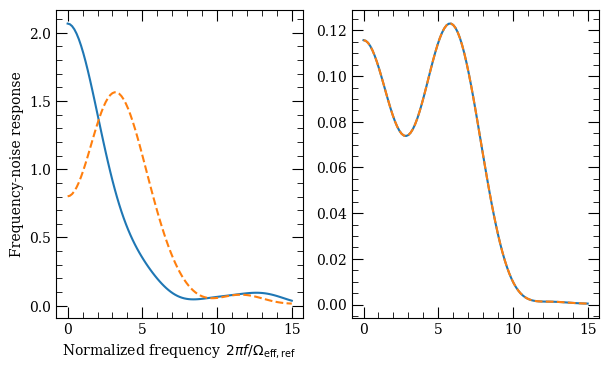

In [10]:
S_haar = isometry_haar_full()   # D=4
fs = np.linspace(0,15,101)
omegas = fs*2*np.pi
oOseq_I1 = build_Oseq_2photon(phases=phase, dt=dt_real, B=blockade_mrad, Omega1=Omega1_0, Omega2=Omega2_0, delta1=delta1, 
                        delta2=delta2, Delta=Delta, inter_detuning=inter_detuning, n=n, Oinst_func=O2photon_I1)
oOseq_I2 = build_Oseq_2photon(phases=phase, dt=dt_real, B=blockade_mrad, Omega1=Omega1_0, Omega2=Omega2_0, delta1=delta1, 
                        delta2=delta2, Delta=Delta, inter_detuning=inter_detuning, n=n, Oinst_func=O2photon_I2)
oOseq_nu1 = build_Oseq_2photon(phases=phase, dt=dt_real, B=blockade_mrad, Omega1=Omega1_0, Omega2=Omega2_0, delta1=delta1, 
                        delta2=delta2, Delta=Delta, inter_detuning=inter_detuning, n=n, Oinst_func=O2photon_nu1)
oOseq_nu2 = build_Oseq_2photon(phases=phase, dt=dt_real, B=blockade_mrad, Omega1=Omega1_0, Omega2=Omega2_0, delta1=delta1, 
                        delta2=delta2, Delta=Delta, inter_detuning=inter_detuning, n=n, Oinst_func=O2photon_nu2)

I_I1_haar = np.array([response_2photon(oOseq_I1, S_haar, omega, dt_real) for omega in omegas])

I_I2_haar = np.array([response_2photon(oOseq_I2, S_haar, omega, dt_real) for omega in omegas])
I_nu1_haar = np.array([response_2photon(oOseq_nu1, S_haar, omega, dt_real) for omega in omegas])
I_nu2_haar = np.array([response_2photon(oOseq_nu2, S_haar, omega, dt_real) for omega in omegas])

fig, ax = plt.subplots(ncols=2,figsize=(7,4))
ax[0].plot(fs, I_I1_haar, label=r"$I_{I1}$ Haar")
ax[0].plot(fs, I_I2_haar, "--",  label=r"$I_{I2}$ Haar")
ax[1].plot(fs, I_nu1_haar, label=r"$I_{\nu1}$ Haar")
ax[1].plot(fs, I_nu2_haar,  "--", label=r"$I_{\nu2}$ Haar")
ax[0].set_xlabel(r"Normalized frequency $\,2 \pi f/\Omega_{\mathrm{eff,ref}}$")
ax[0].set_ylabel("Frequency-noise response")
# plt.legend(frameon=False)
# plt.tight_layout()
fig.show()


# I_nu_haar /= Omega_Rabi**2

In [32]:
1/2*hbar*30e3*2*np.pi/kb

7.198788395892075e-07

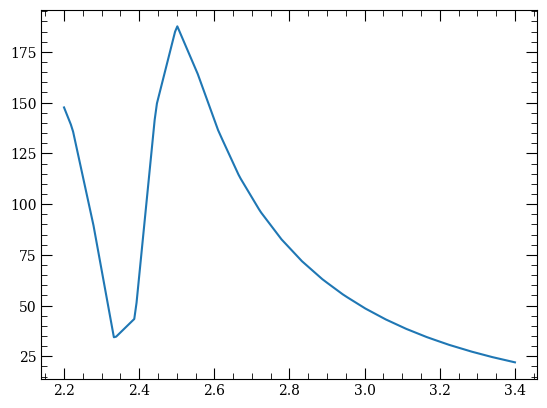

In [18]:
x = np.linspace(2.2, 3.4, 200)
blockade = [find_blockade_Mrad(atom_name, 65, y)/2/np.pi for y in x]
plt.plot(x,blockade)

(array([2.000e+01, 1.110e+02, 3.900e+02, 9.840e+02, 1.741e+03, 2.153e+03,
        1.966e+03, 1.386e+03, 6.650e+02, 3.290e+02, 1.430e+02, 5.900e+01,
        2.400e+01, 1.400e+01, 9.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.9927224 , 2.03365031, 2.07457821, 2.11550611, 2.15643401,
        2.19736192, 2.23828982, 2.27921772, 2.32014562, 2.36107353,
        2.40200143, 2.44292933, 2.48385723, 2.52478513, 2.56571304,
        2.60664094, 2.64756884, 2.68849674, 2.72942465, 2.77035255,
        2.81128045]),
 <BarContainer object of 20 artists>)

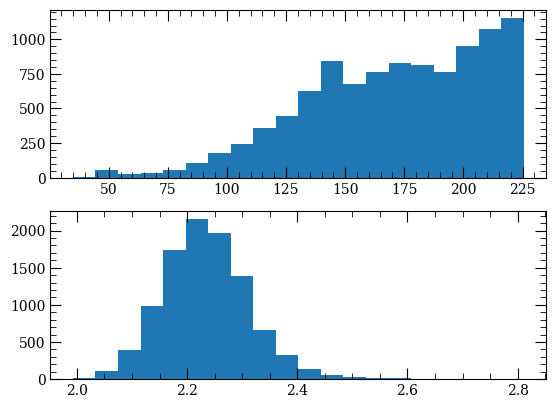

In [19]:
blockade = []
for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
    blockade.append(find_blockade_Mrad(atom_name, n, d)/2/np.pi)
fig, ax = plt.subplots(nrows=2)
ax[0].hist(blockade, bins=20)
ax[1].hist(ds, bins=20)

<h2>Shot-to-shot detuning</h2>

In [81]:
deltas = np.linspace(0,0.1, 100)
deltas *= Omega_Rabi
infids_mean = []
infids_std  = []
for delta in deltas:
    infids_s = []
    for i in range(num_samples):
        d = sample_gaussian(delta)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=d, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

KeyboardInterrupt: 

In [ ]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fractional_delta = deltas/Omega_Rabi
fig, ax = plt.subplots()
ax.plot(fractional_delta, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    fractional_delta,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$\delta \Delta_{DC}/ \Omega $", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)
# fig.show()
# ax.legend()

-0.0001570280038832724
0.9961896423700553


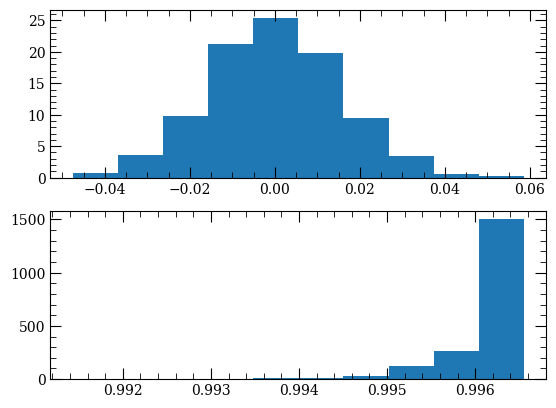

In [110]:
fig, ax = plt.subplots(nrows=2)

ax[0].hist(params, density=True)
ax[1].hist(infids, density= True)
print(np.mean(params))
print(np.mean(infids))

<h2>shot-to-shot Blockade</h2>

In [152]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []
    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    distances = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )[0]
    for d in distances:
        blockade = find_blockade_Mrad(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

Text(0, 0.5, '$1 - \\mathcal{F}$')

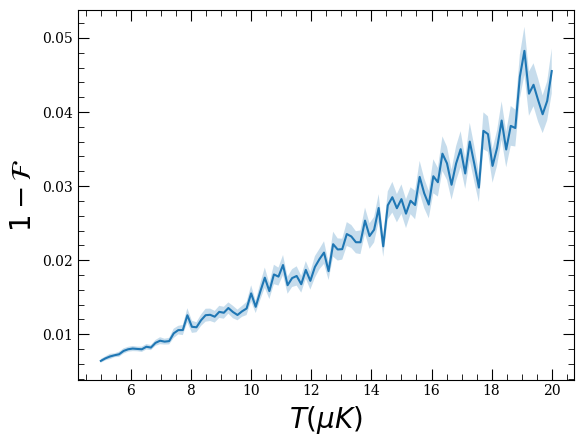

In [156]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(T_atoms, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    T_atoms,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$T(\mu K)$", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

<h2>shot-to-shot Intensity</h2>

In [49]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    d, c1, c2, = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )
    x1 = c1['x']
    y1 = c1['y']
    z1 = c1['z']
    x2 = c2['x']
    y2 = c2['y']
    z2 = c2['z']
    rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
    rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    for rabi1, rabi2 in zip(rabis1, rabis2):
        fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

Text(0, 0.5, '$1 - \\mathcal{F}$')

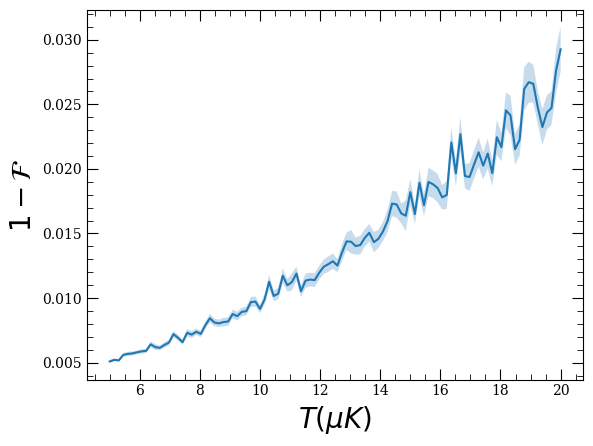

In [50]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(T_atoms, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    T_atoms,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$T(\mu K)$", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

In [159]:
delta_omegas = np.linspace(0,0.1, 100)
infids_mean = []
infids_std  = []
for delta_omega in delta_omegas:
    infids_s = []
    for i in range(num_samples):
        omega_scaled = sample_gaussian(delta_omega)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt, omega_scale=(1-omega_scaled))
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

Text(0, 0.5, '$1 - \\mathcal{F}$')

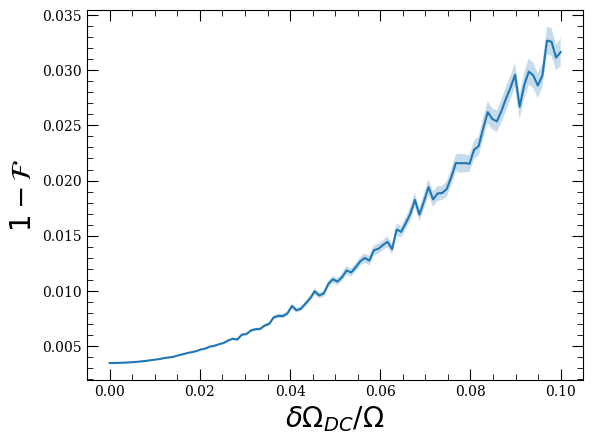

In [173]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(delta_omegas, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    delta_omegas,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$\delta \Omega_{DC}/ \Omega $", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

<h2>Atom motion</h2>

In [60]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []

    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    ds, c1, c2, = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )
    
    x1 = c1['x']
    y1 = c1['y']
    z1 = c1['z']
    x2 = c2['x']
    y2 = c2['y']
    z2 = c2['z']
    rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
    rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
        blockade = find_blockade_Mrad(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

<h2>Read infdel</h2>

In [178]:
result = np.load('results/infid_raw.npz')

In [183]:
print(result['x_detuning'])

[0.         0.0010101  0.0020202  0.0030303  0.0040404  0.00505051
 0.00606061 0.00707071 0.00808081 0.00909091 0.01010101 0.01111111
 0.01212121 0.01313131 0.01414141 0.01515152 0.01616162 0.01717172
 0.01818182 0.01919192 0.02020202 0.02121212 0.02222222 0.02323232
 0.02424242 0.02525253 0.02626263 0.02727273 0.02828283 0.02929293
 0.03030303 0.03131313 0.03232323 0.03333333 0.03434343 0.03535354
 0.03636364 0.03737374 0.03838384 0.03939394 0.04040404 0.04141414
 0.04242424 0.04343434 0.04444444 0.04545455 0.04646465 0.04747475
 0.04848485 0.04949495 0.05050505 0.05151515 0.05252525 0.05353535
 0.05454545 0.05555556 0.05656566 0.05757576 0.05858586 0.05959596
 0.06060606 0.06161616 0.06262626 0.06363636 0.06464646 0.06565657
 0.06666667 0.06767677 0.06868687 0.06969697 0.07070707 0.07171717
 0.07272727 0.07373737 0.07474747 0.07575758 0.07676768 0.07777778
 0.07878788 0.07979798 0.08080808 0.08181818 0.08282828 0.08383838
 0.08484848 0.08585859 0.08686869 0.08787879 0.08888889 0.0898

<h2>Stark shift</h2>

In [65]:
inter_detuning = 5e3*2*np.pi #MHz
Omega1 = np.sqrt(Omega_Rabi*inter_detuning)
omega_photon1 = atom.getTransitionFrequency(n1=6, l1=0, j1=1/2, n2=7, l2=1, j2=1/2, s=0.5)
omega_photon1 += inter_detuning/2/np.pi

d_blue = atom.getDipoleMatrixElement(n1=6, l1=0, j1=1/2, mj1=-1/2, n2=7, l2=1, j2=1/2, mj2=1/2,q=1, s=0.5)*bohr_r/hbar*e
d_red = atom.getDipoleMatrixElement(n1=7, l1=1, j1=1/2, mj1=1/2, n2=n, l2=0, j2=1/2, mj2=-1/2,q=-1, s=0.5)*bohr_r/hbar*e
alpha_g_gen = DynamicPolarizability(atom, n=6, l=0, j=1/2, s=0.5)
alpha_g_gen.defineBasis(6, 9)
alpha_g = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

alpha_e_gen = DynamicPolarizability(atom, n=7, l=1, j=1/2, s=0.5)
alpha_e_gen.defineBasis(6, 9)
alpha_e = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

alpha_e_gen = DynamicPolarizability(atom, n=60, l=0, j=1/2, s=0.5)
alpha_e_gen.defineBasis(7, 75)
alpha_e = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

In [63]:
alpha_g

(np.float64(-414.8262903124463),
 np.float64(829.6525782720447),
 -0.0,
 3.892727808e-07,
 np.float64(1.2650666328922317e-06),
 [np.int64(7), 1, 0.5, 0.5])